# CATBOOST

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
import shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


/Users/khadijaaassi/Desktop/Simplon/Projet_devIA/Simplon_SBA-modelisation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model 1

In [2]:

# Charger les données
df = pd.read_csv('/Users/khadijaaassi/Desktop/Simplon/Projet_devIA/Simplon_SBA-modelisation/data/cleaned_data.csv')


In [3]:
# df['MIS_Status'] = df['MIS_Status'].fillna(
#     df['ChgOffDate'].apply(lambda x: 'P I F' if pd.isna(x) else 'CHGOFF')
# )

# df['MIS_Status'].isna().sum()

In [4]:

# Définition des features et de la cible
features = ['State', 'NAICS', 'ApprovalFY', 'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'SBA_Appv', 'Bank', 'Term']

X = df[features]
y = df['MIS_Status']

# Conversion des catégories en chaînes de caractères
cat_features = ['State', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'Bank']
for col in cat_features:
    X[col] = X[col].astype(str)

# Remplacement des valeurs NaN
X.fillna("Unknown", inplace=True)

# Séparation en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y
)

# Définition du modèle CatBoost
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100
)

# Entraînement du modèle avec déclaration des features catégoriques
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_features)

# Prédictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/2026326733.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/2026326733.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/2026326733.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

0:	test: 0.8889072	best: 0.8889072 (0)	total: 556ms	remaining: 9m 15s
100:	test: 0.9734304	best: 0.9734304 (100)	total: 34s	remaining: 5m 2s
200:	test: 0.9780162	best: 0.9780162 (200)	total: 1m 5s	remaining: 4m 19s
300:	test: 0.9799178	best: 0.9799178 (300)	total: 1m 35s	remaining: 3m 41s
400:	test: 0.9810413	best: 0.9810413 (400)	total: 2m 6s	remaining: 3m 8s
500:	test: 0.9816997	best: 0.9816997 (500)	total: 2m 38s	remaining: 2m 37s
600:	test: 0.9821305	best: 0.9821305 (600)	total: 3m 10s	remaining: 2m 6s
700:	test: 0.9824796	best: 0.9824796 (700)	total: 3m 43s	remaining: 1m 35s
800:	test: 0.9826691	best: 0.9826691 (800)	total: 4m 13s	remaining: 1m 2s
900:	test: 0.9828666	best: 0.9828666 (900)	total: 4m 45s	remaining: 31.4s
999:	test: 0.9830422	best: 0.9830428 (998)	total: 5m 16s	remaining: 0us

bestTest = 0.9830428224
bestIteration = 998

Shrink model to first 999 iterations.


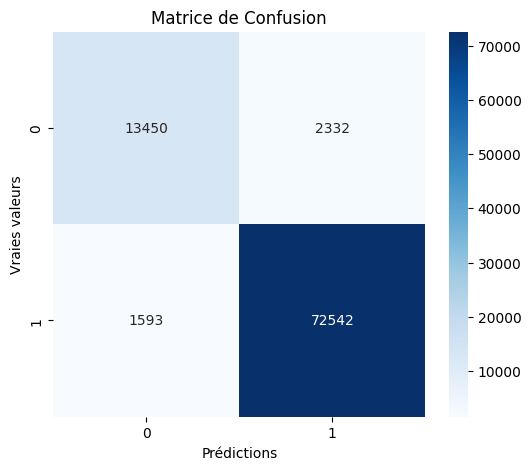

In [5]:
# Matrice de confusion en heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()

In [6]:
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


Rapport de classification :
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.96     89917
   macro avg       0.93      0.92      0.92     89917
weighted avg       0.96      0.96      0.96     89917



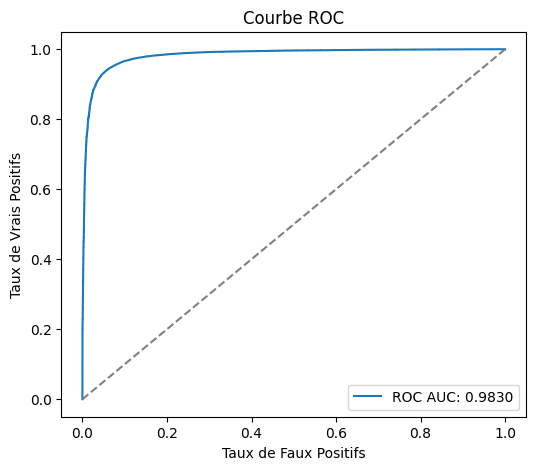

In [7]:
# Courbe ROC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC: {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

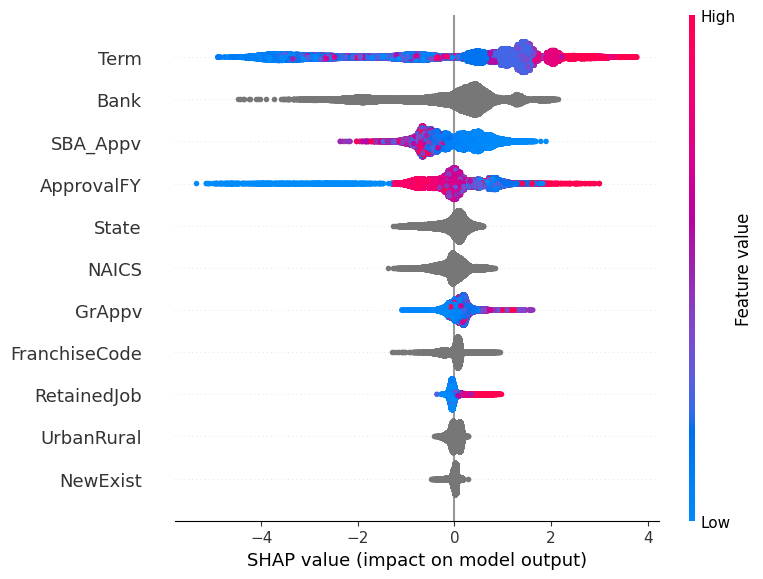

In [8]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

## Model 2

Sans SBA_Approval

In [9]:

# Définition des features et de la cible
features = ['State', 'NAICS', 'ApprovalFY', 'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'Bank', 'Term']

X = df[features]
y = df['MIS_Status']

# Conversion des catégories en chaînes de caractères
cat_features = ['State', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'Bank']
for col in cat_features:
    X[col] = X[col].astype(str)

# Remplacement des valeurs NaN
X.fillna("Unknown", inplace=True)

# Séparation en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y
)

# Définition du modèle CatBoost
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100
)

# Entraînement du modèle avec déclaration des features catégoriques
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_features)

# Prédictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/656926463.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/656926463.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/656926463.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

0:	test: 0.8900307	best: 0.8900307 (0)	total: 291ms	remaining: 4m 50s
100:	test: 0.9728674	best: 0.9728674 (100)	total: 30.4s	remaining: 4m 30s
200:	test: 0.9780481	best: 0.9780481 (200)	total: 59.6s	remaining: 3m 56s
300:	test: 0.9798894	best: 0.9798894 (300)	total: 1m 29s	remaining: 3m 28s
400:	test: 0.9808351	best: 0.9808351 (400)	total: 2m	remaining: 2m 59s
500:	test: 0.9814819	best: 0.9814819 (500)	total: 2m 32s	remaining: 2m 31s
600:	test: 0.9818492	best: 0.9818492 (600)	total: 3m 3s	remaining: 2m 1s
700:	test: 0.9821144	best: 0.9821144 (700)	total: 3m 34s	remaining: 1m 31s
800:	test: 0.9823341	best: 0.9823342 (799)	total: 4m 7s	remaining: 1m 1s
900:	test: 0.9825153	best: 0.9825153 (900)	total: 4m 39s	remaining: 30.7s
999:	test: 0.9826760	best: 0.9826760 (999)	total: 5m 16s	remaining: 0us

bestTest = 0.9826760425
bestIteration = 999



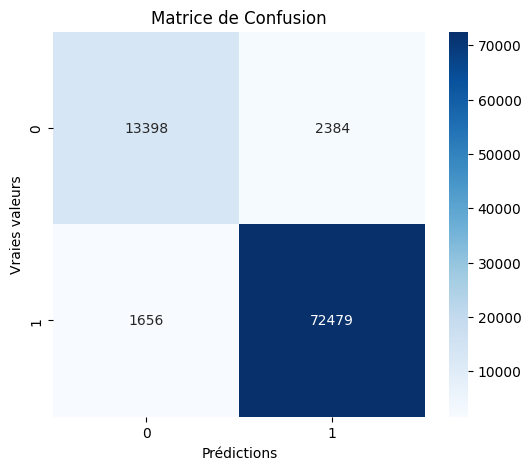

In [10]:
# Matrice de confusion en heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()

In [11]:
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


Rapport de classification :
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.96     89917
   macro avg       0.93      0.91      0.92     89917
weighted avg       0.95      0.96      0.95     89917



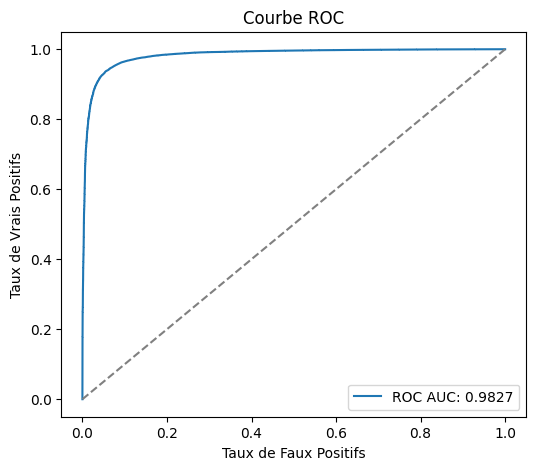

In [12]:
# Courbe ROC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC: {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()


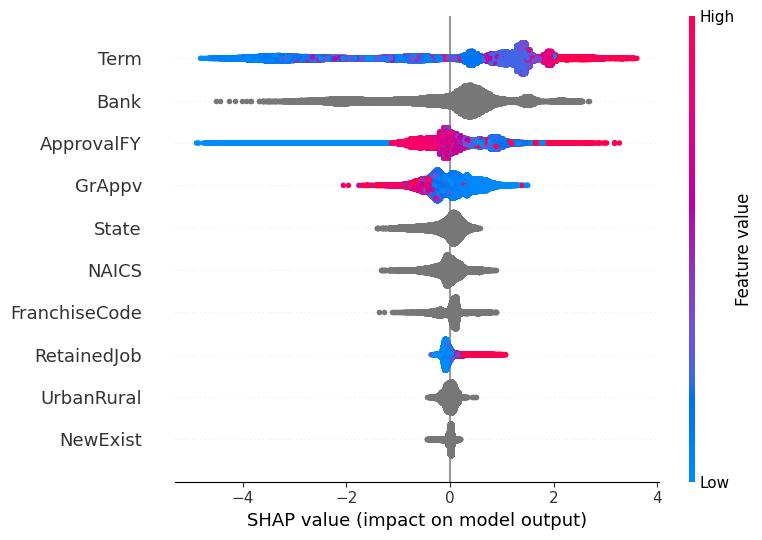

In [13]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

## Model 3

Sans ApprovalFY

In [14]:

# Définition des features et de la cible
features = ['State', 'NAICS',  'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'Bank', 'Term']

X = df[features]
y = df['MIS_Status']

# Conversion des catégories en chaînes de caractères
cat_features = ['State', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'Bank']
for col in cat_features:
    X[col] = X[col].astype(str)

# Remplacement des valeurs NaN
X.fillna("Unknown", inplace=True)

# Séparation en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y
)

# Définition du modèle CatBoost
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100
)

# Entraînement du modèle avec déclaration des features catégoriques
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_features)

# Prédictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/3684798013.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/3684798013.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/3684798013.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

0:	test: 0.8769011	best: 0.8769011 (0)	total: 451ms	remaining: 7m 30s
100:	test: 0.9700137	best: 0.9700137 (100)	total: 36.2s	remaining: 5m 22s
200:	test: 0.9750742	best: 0.9750742 (200)	total: 1m 12s	remaining: 4m 48s
300:	test: 0.9769730	best: 0.9769730 (300)	total: 1m 50s	remaining: 4m 16s
400:	test: 0.9779628	best: 0.9779628 (400)	total: 2m 29s	remaining: 3m 43s
500:	test: 0.9785676	best: 0.9785676 (500)	total: 3m 9s	remaining: 3m 8s
600:	test: 0.9789395	best: 0.9789395 (600)	total: 3m 43s	remaining: 2m 28s
700:	test: 0.9792336	best: 0.9792336 (700)	total: 4m 22s	remaining: 1m 52s
800:	test: 0.9794689	best: 0.9794689 (800)	total: 4m 59s	remaining: 1m 14s
900:	test: 0.9796656	best: 0.9796656 (900)	total: 5m 35s	remaining: 36.9s
999:	test: 0.9798330	best: 0.9798330 (999)	total: 6m 12s	remaining: 0us

bestTest = 0.9798329912
bestIteration = 999



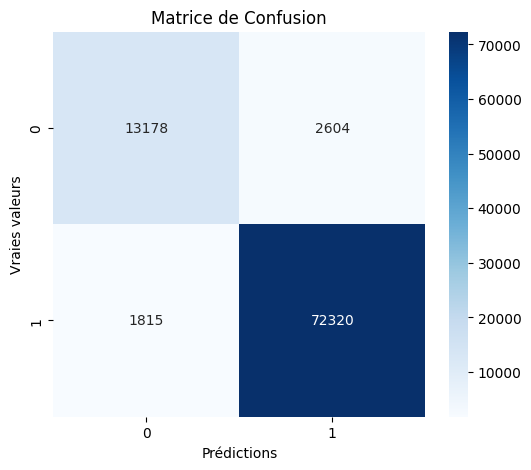

In [15]:
# Matrice de confusion en heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()


In [16]:
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))



Rapport de classification :
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.91      0.91     89917
weighted avg       0.95      0.95      0.95     89917



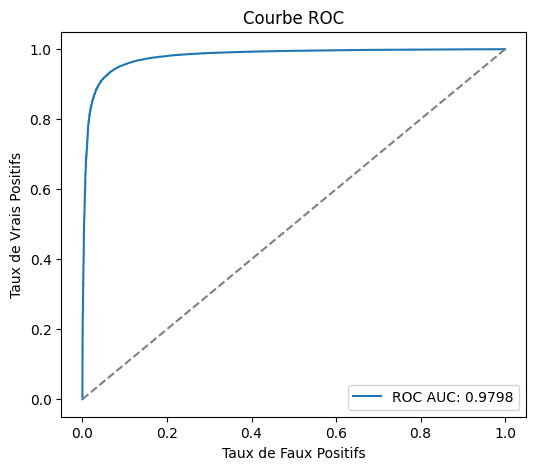

In [17]:

# Courbe ROC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC: {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()


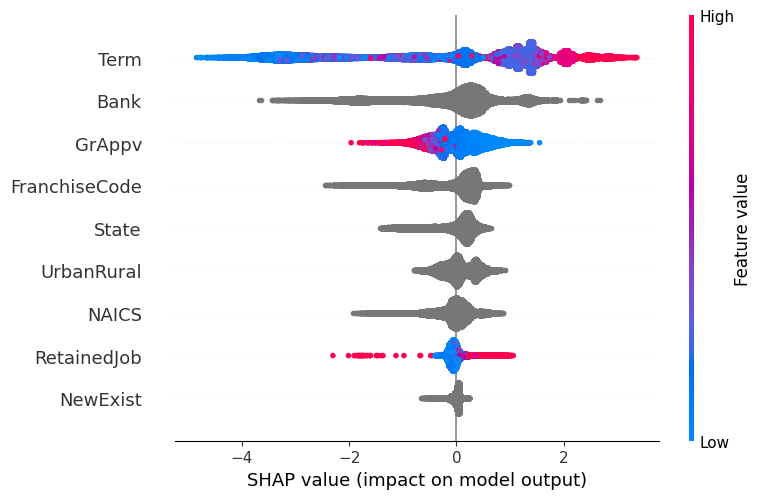

In [18]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

## Model 2

Ajout de la colonne crisis

In [19]:
annee_crise = [1960,1961,1969,1970,1973,1974,1980,1981,1982,2000,2001,2007,2008]
df['Crisis'] = df['ApprovalFY'].apply(lambda x : 1 if x in annee_crise else 0)

In [20]:
# Définition des features et de la cible
features = ['State', 'NAICS',  'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'Bank', 'Term']

X = df[features]
y = df['MIS_Status']

# Conversion des catégories en chaînes de caractères
cat_features = ['State', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'Bank']
for col in cat_features:
    X[col] = X[col].astype(str)

# Remplacement des valeurs NaN
X.fillna("Unknown", inplace=True)

# Séparation en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y
)

# Définition du modèle CatBoost
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100
)

# Entraînement du modèle avec déclaration des features catégoriques
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_features)

# Prédictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/1687161490.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/1687161490.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype(str)
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/1687161490.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

0:	test: 0.8769011	best: 0.8769011 (0)	total: 476ms	remaining: 7m 55s
100:	test: 0.9700137	best: 0.9700137 (100)	total: 35.6s	remaining: 5m 16s
200:	test: 0.9750742	best: 0.9750742 (200)	total: 1m 11s	remaining: 4m 44s
300:	test: 0.9769730	best: 0.9769730 (300)	total: 1m 47s	remaining: 4m 9s
400:	test: 0.9779628	best: 0.9779628 (400)	total: 2m 25s	remaining: 3m 36s
500:	test: 0.9785676	best: 0.9785676 (500)	total: 3m 3s	remaining: 3m 2s
600:	test: 0.9789395	best: 0.9789395 (600)	total: 3m 43s	remaining: 2m 28s
700:	test: 0.9792336	best: 0.9792336 (700)	total: 4m 23s	remaining: 1m 52s
800:	test: 0.9794689	best: 0.9794689 (800)	total: 5m 3s	remaining: 1m 15s
900:	test: 0.9796656	best: 0.9796656 (900)	total: 5m 40s	remaining: 37.4s
999:	test: 0.9798330	best: 0.9798330 (999)	total: 6m 19s	remaining: 0us

bestTest = 0.9798329912
bestIteration = 999



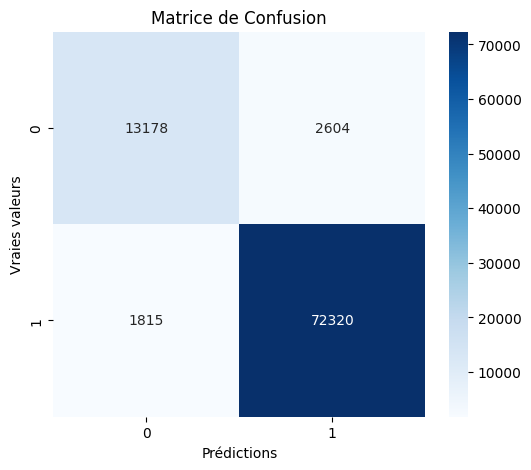

In [21]:
# Matrice de confusion en heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()


In [22]:
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))



Rapport de classification :
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     15782
           1       0.97      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.91      0.91     89917
weighted avg       0.95      0.95      0.95     89917



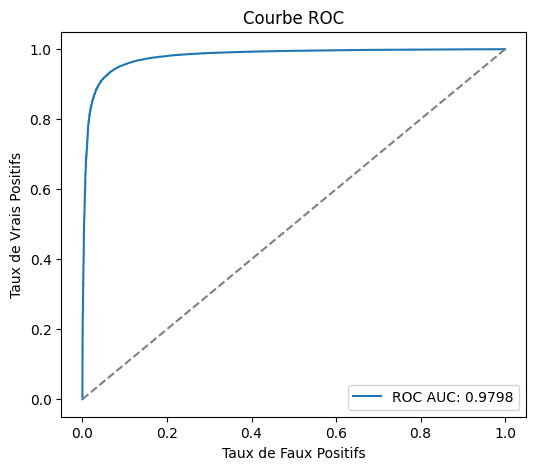

In [23]:
# Courbe ROC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC: {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()


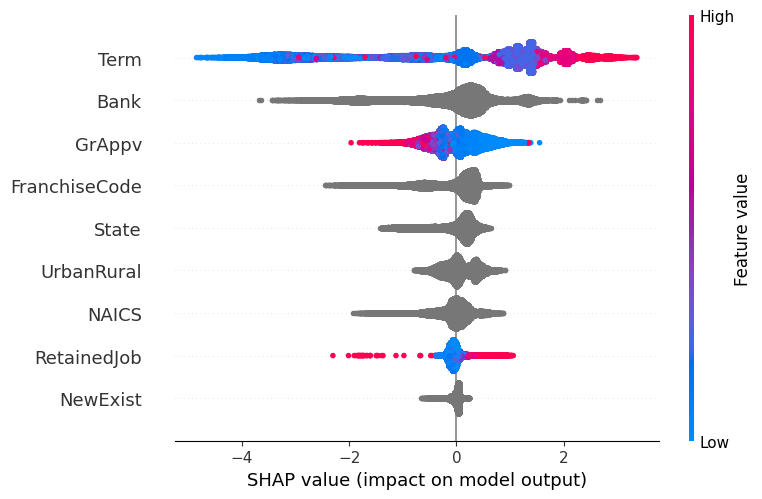

In [24]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

## Model 5 (données  brut)

Travail sur le dataset de base.

In [25]:
df = pd.read_csv('/Users/khadijaaassi/Desktop/Simplon/Projet_devIA/Simplon_SBA-modelisation/data/SBAnational.csv')


/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/1816372278.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/khadijaaassi/Desktop/Simplon/Projet_devIA/Simplon_SBA-modelisation/data/SBAnational.csv')


In [26]:
df["GrAppv"] = (df["GrAppv"].str.replace('[\$,]', '', regex=True).str.strip().astype(float))


<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/1115507837.py:1: SyntaxWarning: invalid escape sequence '\$'
  df["GrAppv"] = (df["GrAppv"].str.replace('[\$,]', '', regex=True).str.strip().astype(float))


In [27]:

# Définition des features et de la cible
features = ['State', 'NAICS', 'NewExist', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'GrAppv', 'Bank', 'Term']

# Suppression des lignes où la cible est NaN
df_clean = df.dropna(subset=['MIS_Status'])

X = df_clean[features].copy()
y = df_clean['MIS_Status']

y = y.map({'P I F': 1, 'CHGOFF': 0})

# Liste des variables catégoriques
cat_features = ['State', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'Bank']

# Vérification des NaN AVANT traitement
print("NaN avant traitement :", X.isna().sum().sum())

# Traitement des valeurs manquantes avec méthode compatible Pandas 3.0
X.loc[:, X.select_dtypes(include=['number']).columns] = X.select_dtypes(include=['number']).fillna(-999)
X.loc[:, cat_features] = X[cat_features].astype(str).fillna("Unknown")

# Vérification des NaN APRÈS traitement
print("NaN après traitement :", X.isna().sum().sum())  # Doit être 0
print("NaN dans y après traitement :", y.isna().sum())  # Doit être 0

# Séparation en train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y
)

# Vérification des NaN après split
print("NaN après split - Train :", X_train.isna().sum().sum())  # Doit être 0
print("NaN après split - Test :", X_test.isna().sum().sum())  # Doit être 0

# Indices des colonnes catégoriques
cat_features_idx = [X.columns.get_loc(col) for col in cat_features if col in X.columns]
print("cat_features_idx :", cat_features_idx)

# Définition du modèle CatBoost
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100
)

# Entraînement du modèle
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_features_idx)

# Prédictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


NaN avant traitement : 1653


/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/2970449347.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['451120' '722410' '621210' ... '332321' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, cat_features] = X[cat_features].astype(str).fillna("Unknown")
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/2970449347.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2.0' '2.0' '1.0' ... '1.0' '1.0' '2.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[:, cat_features] = X[cat_features].astype(str).fillna("Unknown")
/var/folders/bl/7f1kdky90j199bncllgc2ntc0000gn/T/ipykernel_73403/2970449347.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error

NaN après traitement : 0
NaN dans y après traitement : 0
NaN après split - Train : 0
NaN après split - Test : 0
cat_features_idx : [0, 1, 2, 4, 5, 7]
0:	test: 0.8704208	best: 0.8704208 (0)	total: 469ms	remaining: 3m 53s
100:	test: 0.9706338	best: 0.9706338 (100)	total: 41.5s	remaining: 2m 44s
200:	test: 0.9760199	best: 0.9760199 (200)	total: 1m 25s	remaining: 2m 6s
300:	test: 0.9780101	best: 0.9780101 (300)	total: 2m 7s	remaining: 1m 24s
400:	test: 0.9789539	best: 0.9789539 (400)	total: 2m 53s	remaining: 42.8s
499:	test: 0.9795593	best: 0.9795593 (499)	total: 3m 40s	remaining: 0us

bestTest = 0.9795593082
bestIteration = 499



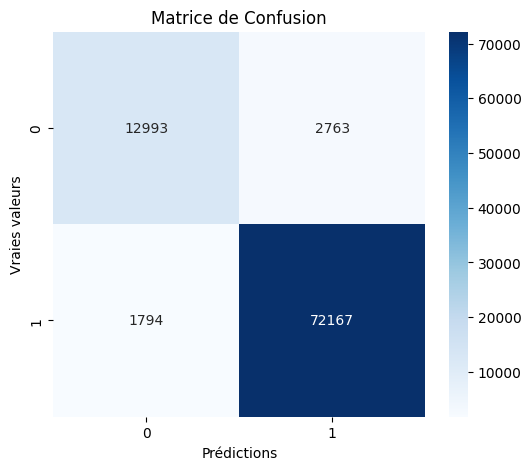

In [28]:
# Matrice de confusion en heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")

plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()


In [29]:
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))



Rapport de classification :
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15756
           1       0.96      0.98      0.97     73961

    accuracy                           0.95     89717
   macro avg       0.92      0.90      0.91     89717
weighted avg       0.95      0.95      0.95     89717



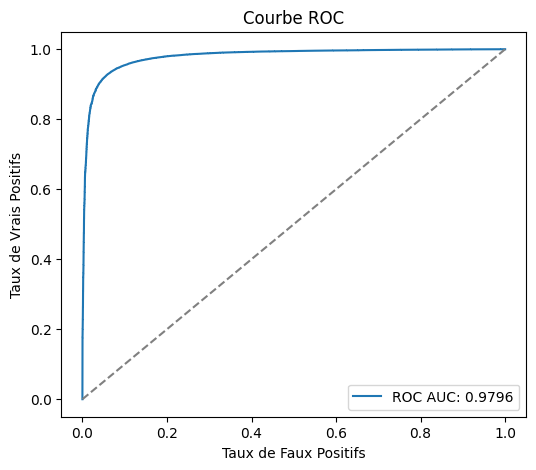

In [30]:
# Courbe ROC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC: {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()


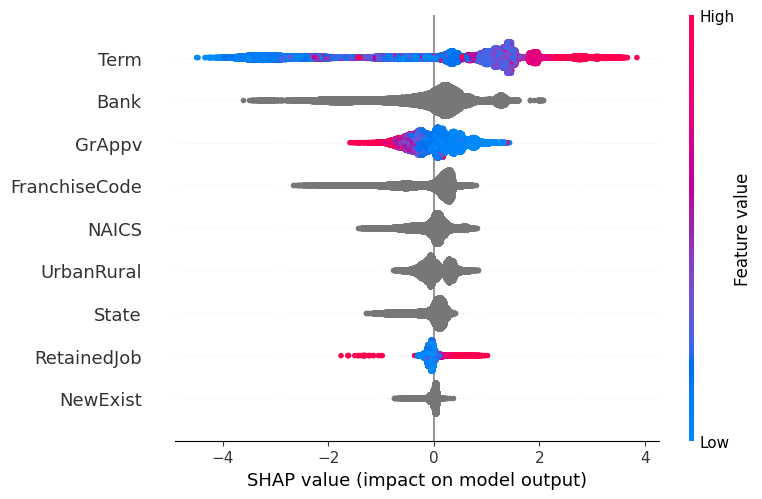

In [31]:

# SHAP pour interprétabilité
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)